In [1]:
import numpy as np
from numpy import trapz
import pandas as pd

from os import listdir

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.style as style
style.use('seaborn-whitegrid')
font = {'size' : 12}
figure = {'titlesize' : 18}
plt.rc('font', **font)
plt.rc('figure', **figure)

import seaborn as sns
sns.set(font_scale=1.2)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
from tabulate import tabulate

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

---

# Import

In [2]:
path = 'datasets/'
df = pd.read_csv(path + 'US_youtube_trending_data.csv')

---

# Overview

In [3]:
df.shape

(56391, 16)

In [4]:
df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description'],
      dtype='object')

In [5]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


In [6]:
df.describe()

,categoryId,view_count,likes,dislikes,comment_count
count,56391.00,56391.00,56391.00,56391.00,56391.00
mean,18.62,2774104.35,152217.89,3419.31,15757.57
std,7.05,6495728.16,431041.45,15311.90,112172.57
min,1.00,0.00,0.00,0.00,0.00
25%,10.00,552122.50,21002.50,394.00,1912.00
50%,20.00,1140492.00,53286.00,925.00,4370.00
75%,24.00,2554232.00,133557.00,2517.00,10467.50
max,29.00,264407389.00,16021534.00,879354.00,6738537.00


---

# Extracting dates

In [7]:
cols = ['publishedAt', 'trending_date']
df[cols].sample(5)

,publishedAt,trending_date
32575,2021-01-17T13:48:43Z,2021-01-25T00:00:00Z
17441,2020-11-05T01:42:17Z,2020-11-08T00:00:00Z
19586,2020-11-11T22:00:11Z,2020-11-18T00:00:00Z
21321,2020-11-23T22:00:03Z,2020-11-28T00:00:00Z
3330,2020-08-26T12:30:41Z,2020-08-28T00:00:00Z


In [8]:
# extract year, month, day, and hour from time features

date_formats = {'y':[0, 4], 'm':[5, 7], 'd':[8, 10], 'h':[11, 13]}
for col in cols:
    for key, [start, end] in date_formats.items():
        df['{}_{}'.format(col, key)] = df[col].str[start:end].astype(int)

In [9]:
# convert original time features to datetime

for col in cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%dT%H:%M:%SZ')

In [10]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publishedAt_y,publishedAt_m,publishedAt_d,publishedAt_h,trending_date_y,trending_date_m,trending_date_d,trending_date_h
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,2020,8,11,19,2020,8,12,0
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",2020,8,11,17,2020,8,12,0
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,2020,8,11,16,2020,8,12,0
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,2020,8,11,16,2020,8,12,0
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,2020,8,11,15,2020,8,12,0


In [11]:
# drop trending_date_h since all 0

df = df.drop(columns='trending_date_h')

In [12]:
df.shape

(56391, 23)

In [13]:
df_edit = df.copy()

---

# Normalizing Data

In [14]:
def min_max_scale(df: pd.DataFrame) -> pd.DataFrame:
    """
    Description: 
        - Apply min-max scaling to dataframe columns of type float
    Inputs: 
        - df, input dataframe to be normalized
    Returns:
        - df, normalized dataframe
    """
    
    numbered_columns = df.select_dtypes(include=[np.number, np.bool]).columns     # extract columns that are of type float
    scaler = preprocessing.MinMaxScaler()
    df[numbered_columns] = scaler.fit_transform(df[numbered_columns])     # normalize across columns 
    return df.copy()

---

# Splitting Data

In [15]:
def split_data(df: pd.DataFrame, replace_nan: int) -> list:
    """
    Description: 
        - split data into training and testing datasets
    Inputs: 
        - df, input dataframe to be split
        - replace_nan, value to replace nan values found in input dataframe
    Returns:
        - split_list, list containing train-test split of input dataframe
    """
    
    df = df.replace(np.nan, replace_nan).copy()     # replace nan values
    
    X = df.drop(columns=df.columns[-1]).copy()     # remove categorical data
    y = df[df.columns[-1]].copy()
    
    split_list = train_test_split(X, y, random_state=40, test_size=0.3)
    
    print('=== Train shape ===')
    print(split_list[0].shape)
    print()
    
    print('=== Test shape ===')
    print(split_list[1].shape)
    print()
    
    return split_list

---

# Random forest

In [16]:
res = {}

## Building dataset

In [17]:
df = df_edit.copy()

In [18]:
df['view_count'].describe()

count       56391.00
mean      2774104.35
std       6495728.16
min             0.00
25%        552122.50
50%       1140492.00
75%       2554232.00
max     264407389.00
Name: view_count, dtype: float64

In [19]:
d_view_ranks = {
    'F':0, 'E':250000, 'D':500000, 'C':1000000, 'B':5000000, 'A':10000000,
}

for key, value in d_view_ranks.items():
    df.loc[df['view_count'] >= value, 'view_count_cat'] = key

In [20]:
df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description', 'publishedAt_y', 'publishedAt_m',
       'publishedAt_d', 'publishedAt_h', 'trending_date_y', 'trending_date_m',
       'trending_date_d', 'view_count_cat'],
      dtype='object')

In [21]:
df.dtypes

video_id                     object
title                        object
publishedAt          datetime64[ns]
channelId                    object
channelTitle                 object
categoryId                    int64
trending_date        datetime64[ns]
tags                         object
view_count                    int64
likes                         int64
dislikes                      int64
comment_count                 int64
thumbnail_link               object
comments_disabled              bool
ratings_disabled               bool
description                  object
publishedAt_y                 int64
publishedAt_m                 int64
publishedAt_d                 int64
publishedAt_h                 int64
trending_date_y               int64
trending_date_m               int64
trending_date_d               int64
view_count_cat               object
dtype: object

In [22]:
df = df['likes dislikes comment_count comments_disabled ratings_disabled view_count_cat'.split()]
df_norm = min_max_scale(df.copy())
df_norm.head()

,likes,dislikes,comment_count,comments_disabled,ratings_disabled,view_count_cat
0,0.01,0.01,0.01,0.00,0.00,C
1,0.01,0.00,0.00,0.00,0.00,C
2,0.02,0.00,0.01,0.00,0.00,C
3,0.00,0.00,0.00,0.00,0.00,E
4,0.00,0.00,0.00,0.00,0.00,C


In [23]:
df_norm['view_count_cat'].value_counts()

C    24090
D    13246
E     8819
B     3964
F     3513
A     2759
Name: view_count_cat, dtype: int64

## Running model

In [24]:
def random_forest_fit(df, model_arguments):
    
    
    # replacing nan value with -1
    X_train, X_test, y_train, y_test = split_data(df, -1)
    
    
    # create logistic regression model

    model = RandomForestClassifier(
        n_estimators=model_arguments['n_estimators'],
        criterion=model_arguments['criterion'],
        max_depth=model_arguments['max_depth'],
        min_samples_split=model_arguments['min_samples_split'],
        min_samples_leaf=model_arguments['min_samples_leaf'],
        min_weight_fraction_leaf=model_arguments['min_weight_fraction_leaf'],
        max_features=model_arguments['max_features'],
        max_leaf_nodes=model_arguments['max_leaf_nodes'],
        min_impurity_decrease=model_arguments['min_impurity_decrease'],
        min_impurity_split=model_arguments['min_impurity_split'],
        bootstrap=model_arguments['bootstrap'],
        oob_score=model_arguments['oob_score'],
        n_jobs=model_arguments['n_jobs'],
        random_state=model_arguments['random_state'],
        verbose=model_arguments['verbose'],
        warm_start=model_arguments['warm_start'],
        class_weight=model_arguments['class_weight'],
        ccp_alpha=model_arguments['ccp_alpha'],
        max_samples=model_arguments['max_samples'],
    )
    
    
    # fit data to model
    model.fit(X_train, y_train);
    
    
    return model, X_train, X_test, y_train, y_test

In [25]:
random_forest_default_arguments = {
    'n_estimators':100,
    'criterion':'gini',
    'max_depth':None,
    'min_samples_split':2,
    'min_samples_leaf':1,
    'min_weight_fraction_leaf':0.0,
    'max_features':'auto',
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'min_impurity_split':None,
    'bootstrap':True,
    'oob_score':False,
    'n_jobs':None,
    'random_state':None,
    'verbose':0,
    'warm_start':False,
    'class_weight':None,
    'ccp_alpha':0.0,
    'max_samples':None,
}

model, X_train, X_test, y_train, y_test = random_forest_fit(df_norm, random_forest_default_arguments)

=== Train shape ===
(39473, 5)

=== Test shape ===
(16918, 5)



## Performance

In [26]:
def model_f1(model, X_train, X_test, y_train, y_test):
    
    
    # predict classes using mode
    
    y_pred = model.predict(X_train)
    f1_train = round(f1_score(y_train, y_pred, zero_division=0, average='weighted'), 3)

    y_pred = model.predict(X_test)
    f1_test = round(f1_score(y_test, y_pred, zero_division=0, average='weighted'), 3)

    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    f1_cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted', n_jobs=-1)
    f1_cv_mean = round(f1_cv_scores.mean(), 3)
    
    
    # print scores
    
    print('=== Training f1-score ===')
    print(f1_train)
    print()

    print('=== Testing f1-score ===')
    print(f1_test)
    print()

    print('=== Cross-validating dataset f1-score ===')
    print(f1_cv_mean)
    
    return y_pred, f1_train, f1_test, X, y, f1_cv_scores, f1_cv_mean

In [27]:
# get f1-scores

y_pred, f1_train, f1_test, X, y, f1_cv_scores, f1_cv_mean = model_f1(model, X_train, X_test, y_train, y_test)

=== Training f1-score ===
0.998

=== Testing f1-score ===
0.712

=== Cross-validating dataset f1-score ===
0.713


In [28]:
# classification report

report = classification_report(y_test, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           A       0.83      0.78      0.80       822
           B       0.70      0.57      0.62      1258
           C       0.79      0.85      0.81      7188
           D       0.63      0.61      0.62      4017
           E       0.62      0.62      0.62      2616
           F       0.67      0.59      0.63      1017

    accuracy                           0.71     16918
   macro avg       0.71      0.67      0.68     16918
weighted avg       0.71      0.71      0.71     16918



In [29]:
pd.Series(y_test).value_counts()

C    7188
D    4017
E    2616
B    1258
F    1017
A     822
Name: view_count_cat, dtype: int64

In [30]:
def confusion_matricies(y_test, y_pred):
    
    
    # create matrix
    
    labels = np.sort(pd.Series(y_test).unique())
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    # source: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    df_cm = pd.DataFrame(cm, index = [i for i in labels], columns = [i for i in labels])
    
    
    # plot absolute values
    
    plt.figure(figsize = (10,5))
    sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
    plt.tight_layout()
    plt.show();
    print()
    
    
    # plot normalized values
    
    plt.figure(figsize = (10,5))
    sns.heatmap(df_cm.apply(lambda r: r/r.sum(), axis=1), annot=True, fmt='.3f', cmap="Blues")
    plt.tight_layout()
    plt.show();

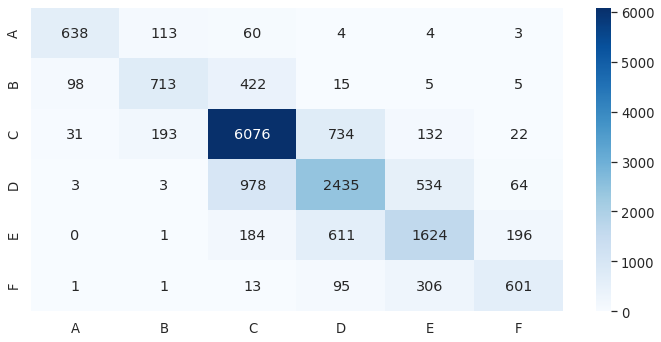

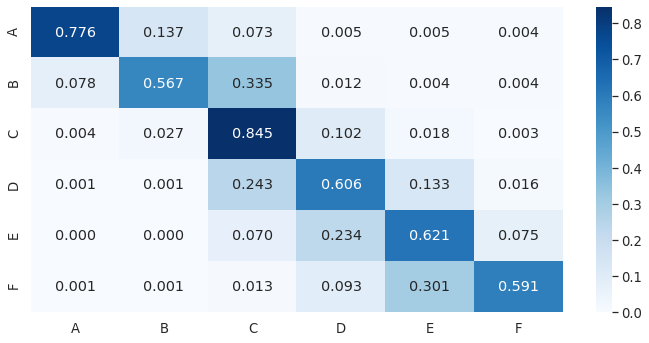

In [31]:
confusion_matricies(y_test, y_pred)

## Feature importance

In [32]:
importance = pd.DataFrame(data=X_train.columns, columns=['features'])
importance['importance_score'] = model.feature_importances_
importance

,features,importance_score
0,likes,0.35
1,dislikes,0.38
2,comment_count,0.27
3,comments_disabled,0.00
4,ratings_disabled,0.00


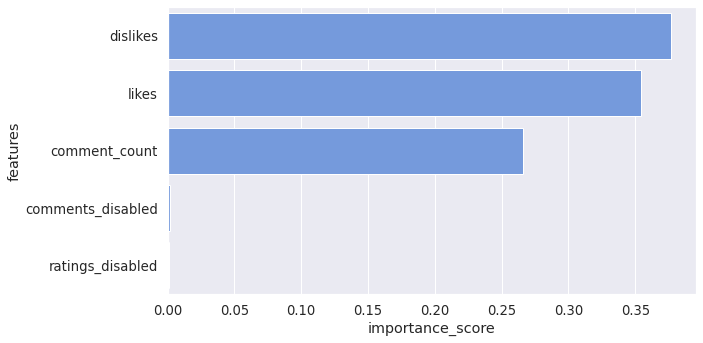

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
bp = sns.barplot(data=importance.sort_values('importance_score', ascending=False), x='importance_score', y='features', color='cornflowerblue');
plt.tight_layout()

---